# Code to Solve the Compressed-Sensing Magnetic Resonance Imaging (CS-MRI) Reconstruction Problem

## Problem formulation

$\boldsymbol{y} = \boldsymbol{M} \odot (\boldsymbol{F} \boldsymbol{X} \boldsymbol{F} + \boldsymbol{\varepsilon}) , \hspace{2ex} \boldsymbol{\varepsilon} \sim \mathcal{N} (0, \sigma^2 \boldsymbol{I}), \hspace{2ex} \sigma \geq 0.$

- $\boldsymbol{X} \in \mathbb{R}^{n \times n}$: unknown image to recover 
- $\boldsymbol{F} \in \mathbb{C}^{n \times n}$: DFT matrix (https://en.wikipedia.org/wiki/DFT_matrix) 
- $\boldsymbol{M} \in \{0 ,1\}^{n \times n}$: 0-1 mask that denotes which Fourier coefficients are observed 
- $\boldsymbol{\varepsilon} \in \mathbb{R}^{m}$: noise
- $ \sigma \in \mathbb{R}^+$: noise level 
- $ \boldsymbol{y} \in \mathbb{C}^{m}$: observed measurements (Fourier coefficients) 
- $ \odot : \mathbb{C}^{n_1 \times n_2} \times \mathbb{C}^{n_1 \times n_2} \mapsto \mathbb{C}^{n_1 \times n_2}$: denotes the Kronecker product (https://en.wikipedia.org/wiki/Kronecker_product)


## Loss function, gradients

### Loss function:

$\ell ({\boldsymbol{X}}) = \frac{1}{2m} \| \boldsymbol{M} \odot (\boldsymbol{y} - \boldsymbol{F} \boldsymbol{X} \boldsymbol{F}) \|_2^2$

### Loss function as a finite sum:

$\ell (\boldsymbol{X}) := \frac{1}{m} \sum_{\{ i, j | y_{i, j} \not= 0 \}} \ell_{i,j}(\boldsymbol{X}) = \frac{1}{m}\sum_{\{ i, j | y_{i, j} \not= 0 \}} \frac{1}{2}(y_i - \boldsymbol{f}_i^\top \boldsymbol{X} \boldsymbol{f}_j)^2$

- $\boldsymbol{f}_i \in \mathbb{C}^m$: the $i^{\text{th}}$ column of the DFT matrix $\boldsymbol{F}$.


### Full gradient:

$\nabla \ell ({\boldsymbol{X}}) = \frac{1}{m}\boldsymbol{F}^\dagger \boldsymbol{M} \odot(\boldsymbol{y} - \boldsymbol{F} \boldsymbol{X} \boldsymbol{F} ) \boldsymbol{F}^\dagger$

### Stochastic gradient:

$\nabla \ell_{i,j}({\boldsymbol{X}}) = (y_i - \boldsymbol{f}_j^\dagger \boldsymbol{X}^\dagger \boldsymbol{f}_i^\ast) \boldsymbol{f}_j^\dagger\boldsymbol{f}^\ast $

- $\dagger : \mathbb{C}^{n_1 \times n_2} \mapsto \mathbb{C}^{n_2 \times n_1} $: Hermitian transpose
- $\ast : \mathbb{C}^{n_1 \times n_2} \mapsto \mathbb{C}^{n_1 \times n_2} $: Complex conjugate

In [1]:
from ipynb.fs.full.csmri_gradients import full_grad, stoch_grad, get_batch

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import dirname, abspath
import os
import matplotlib.pyplot as plt
from PIL import Image
import time

from skimage import data, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise

In [4]:
np.random.seed(5)

## Set paths
data_path="../data/Set12/"
save_path="./figures/"
image_list = sorted(os.listdir(data_path))

## Read test image
# normalize image pixels in range [0,1]
# orig = np.array(Image.open(data_path + image_list[8])) / 225.0
ORIG = Image.open(data_path + image_list[12]).resize((256,256))
ORIG = np.array(ORIG) / 255.0
mintmp = np.min(ORIG)
maxtmp = np.max(ORIG)
ORIG = (ORIG - mintmp) / (maxtmp - mintmp)

(-0.5, 255.5, 255.5, -0.5)

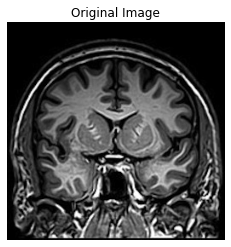

In [5]:
## Display original image
orig_fig = plt.figure()
ax = orig_fig.add_subplot(1, 1, 1)
orig_plot = plt.imshow(ORIG, cmap='gray', vmin=0, vmax=1)
ax.set_title('Original Image')
ax.axis('off')

In [6]:
## Set signal model parameters
prob = .5 							# percentage of Fourier coefficients measured
H, W = ORIG.shape[:2] 				# height and width of orig image
N = H*W 							# image dimension
sigma = 1							# noise level of measurements

## Make measurements
mask = np.random.choice([0, 1], size=(H,W), p=[1 - prob, prob])	# generate random mask
index = np.nonzero(mask)
index = np.transpose(index)

noises = np.random.normal(0, sigma, (H,W))						# generate random noise
forig = np.fft.fft2(ORIG)										# fft2 of image
y0 = np.multiply(forig, mask)									# noiseless measurements
y = y0 + noises 												# noisy measurements

## Initialize variables
x_init = np.abs(np.fft.ifft2(y))
mintmp = np.min(x_init)
maxtmp = np.max(x_init)
x_init = (x_init - mintmp) / (maxtmp - mintmp)
x = np.copy(x_init)

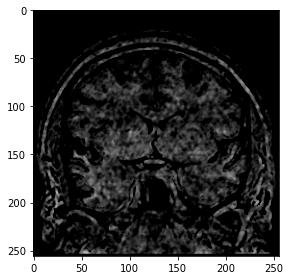

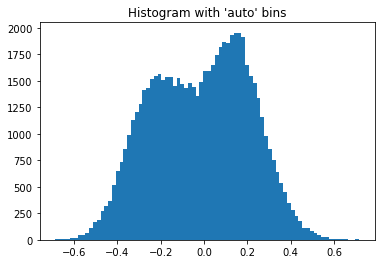

-0.01747919378611587 0.22361355419292903


In [7]:
x_diff = ORIG - x_init

## Display inverse 2D-DFT of observed Fourier coefficients

fig, axs = plt.subplots(1, 1, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs = plt.imshow(x_diff, cmap='gray', vmin=0, vmax=1)
plt.show()

x_diff = np.matrix.flatten(x_diff)

_ = plt.hist(np.matrix.flatten(x_diff), bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

print(np.mean(x_diff), np.std(x_diff))

(-0.5, 255.5, 255.5, -0.5)

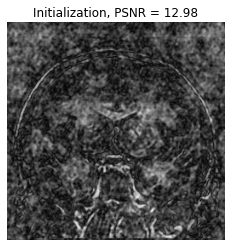

In [8]:
## Display inverse 2D-DFT of observed Fourier coefficients
init_fig = plt.figure()
ax = init_fig.add_subplot(1, 1, 1)
init_plot = plt.imshow(x_init, cmap='gray', vmin=0, vmax=1)
ax.set_title(f'Initialization, PSNR = {peak_signal_noise_ratio(x_init, ORIG):0.2f}')
ax.axis('off')

In [9]:


# filter_array = np.linspace(0, 0.06, 1000)

# patch_kw = dict(patch_size=5,      # 5x5 patches
#                 patch_distance=6,  # 13x13 search area
#                 multichannel=True)

# psnr_list = []
# for i in range(1000):
#     test_denoise = denoise_nl_means(np.real(x_init), h=filter_array[i], fast_mode=True, **patch_kw)
#     psnr_list.append(peak_signal_noise_ratio(test_denoise, ORIG))

# svrg_fig = plt.figure()
# ax = svrg_fig.add_subplot(1, 1, 1)
# svrg_plot = plt.plot(filter_array, psnr_list)
# ax.set_title(f"Filter Size vs. PSNR recovery")
# ax.axis('on')
# plt.show()

$\begin{equation}
	\textbf{PnP-SVRG}(\boldsymbol{x}_0, \eta, T_1, T_2): \\
	\text{for } s = 1, 2, . . ., T_1 \text{ do} \\
	\hspace{2ex} \tilde{\boldsymbol{x}} = \boldsymbol{x}_{s-1} \\
	\hspace{2ex} \boldsymbol{w} = \underbrace{\nabla d(\tilde{\boldsymbol{x}})}_{\text{full gradient}} \\
	\hspace{2ex} \boldsymbol{x}_0 = \tilde{\boldsymbol{x}} \\
	\hspace{2ex} \text{for } t = 1, 2, . . ., T_2 \text{ do} \\
	\hspace{4ex} \text{pick } i_t \in \{ 1, ..., m \} \text{ randomly} \\
	\hspace{4ex} \boldsymbol{v}_t = \underbrace{\nabla d_{i_t} (\boldsymbol{x}_{t-1}) - \nabla d_{i_t} (\tilde{\boldsymbol{x}}) + \boldsymbol{w}}_{\text{stochastic variance-reduced gradient}} \\
	\hspace{4ex} \boldsymbol{x}_t = \text{denoise}_\sigma (\boldsymbol{x}_{t-1} - \eta \boldsymbol{v}_t) \\
	\hspace{2ex} \text{end} \\
	\hspace{2ex} \text{set } \boldsymbol{x}_s = \boldsymbol{x}_{T_2} \\
	\text{end} \\
    \textbf{Output } \boldsymbol{x}_{T_1}
\end{equation}$

In [37]:
def PnP_SVRG_CSMRI(z, MASK, meas, eta, T1, T2, batch_size, FILTER, patch, orig):
    ## See pseudocode above

    ## Obtain info from inputs
    H, W = z.shape[:2] # image dimensions
    index = np.transpose(np.nonzero(MASK)) # nonzero indices of the mask

    ## Initialize time-keeping variables
    time_per_iter = []
    psnr_per_iter = []
    t0 = 0

    ## Main PnP SVRG routine
    for i in range(T1):
        # outer loop
        t1 = 0
        mu = full_grad(z, MASK, meas)   	# Gradient at reference point
        w = np.copy(z) 					# Initialize reference point
        start_iter = time.time()
        for j in range(T2):
            ## inner loop
            ind = get_batch(batch_size, H, W, index) 	# Get batch index(indices) in terms of (row, col)

            ## calculate stochastic variance-reduced gradient
            v = stoch_grad(z, ind, meas) - stoch_grad(w, ind, meas) + mu 

            ## take gradient step
            z = np.real(z - eta*v)

            print("grad " + str(i) + " " + str(j) + " " + str(peak_signal_noise_ratio(orig, z)))            
            
            # Denoising
            ztilde = np.copy(z)
            z = denoise_nl_means(np.real(ztilde), h=FILTER, fast_mode=True, **patch)
            
            # get rescaled version for calculating PSNR
            mintmp = np.min(z)
            maxtmp = np.max(z)
            zp = (z - mintmp) / (maxtmp - mintmp)
            
            print("denoise " + str(i) + " " + str(j) + " " + str(peak_signal_noise_ratio(orig, z)))
            t1 += 1
        ## Calculate time and PSNR difference per outer loop
        stop_iter = time.time()
        time_per_iter.append(stop_iter - start_iter)
        psnr_per_iter.append(peak_signal_noise_ratio(ORIG, z))

        t0 += 1
    ## Output final iterate, time keeping
    return z, time_per_iter, psnr_per_iter

In [72]:
## Run PnP-SVRG
T_outer = 500 				# Number of outer loop iterations
T_inner = 10 				# Number of inner loop iterations
eta_SVRG = .01 				# step size for SVRG
batch_size_SVRG= int(np.rint(np.count_nonzero(mask) / T_inner))
NLM_filter = 0.01
patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

output_SVRG, time_per_iter_SVRG, psnr_per_iter_SVRG = PnP_SVRG_CSMRI(x_init, mask, y, eta_SVRG, \
                                                                     T_outer, T_inner, batch_size_SVRG, \
                                                                     NLM_filter, patch_kw, ORIG)


grad 0 0 13.032398253828951
denoise 0 0 13.032445905507046
grad 0 1 13.08141041189402
denoise 0 1 13.081461206380752
grad 0 2 13.130550915930426
denoise 0 2 13.13060525408014
grad 0 3 13.179881693874492
denoise 0 3 13.179939983678084
grad 0 4 13.229363705420003
denoise 0 4 13.229426606076707
grad 0 5 13.27902832655501
denoise 0 5 13.279094896232714
grad 0 6 13.328768553809558
denoise 0 6 13.328839553990539
grad 0 7 13.378736789080445
denoise 0 7 13.37881300514497
grad 0 8 13.428550087051587
denoise 0 8 13.4286328581539
grad 0 9 13.478295016421063
denoise 0 9 13.478385054797869
grad 1 0 13.52511766626434
denoise 1 0 13.52521419650111
grad 1 1 13.57207309753861
denoise 1 1 13.57217530529607
grad 1 2 13.61909074905033
denoise 1 2 13.619198830156646
grad 1 3 13.666211592995436
denoise 1 3 13.666321310713158
grad 1 4 13.713574662020696
denoise 1 4 13.713683957682212
grad 1 5 13.76103185006376
denoise 1 5 13.76114246097991
grad 1 6 13.80845540280031
denoise 1 6 13.808573666905886
grad 1 7 13

grad 13 9 18.121956603773096
denoise 13 9 18.120075831444485
grad 14 0 18.143941768439685
denoise 14 0 18.142178823654906
grad 14 1 18.166043129247058
denoise 14 1 18.164213733086022
grad 14 2 18.18809062400383
denoise 14 2 18.18626626725826
grad 14 3 18.210140899516716
denoise 14 3 18.208174132793857
grad 14 4 18.232062107162122
denoise 14 4 18.22981961491454
grad 14 5 18.253707708937227
denoise 14 5 18.25120727581116
grad 14 6 18.275061747284667
denoise 14 6 18.27246902905243
grad 14 7 18.29635333389156
denoise 14 7 18.29370669768967
grad 14 8 18.317538448598892
denoise 14 8 18.314890320935383
grad 14 9 18.33834889046959
denoise 14 9 18.33570166942453
grad 15 0 18.35858513648392
denoise 15 0 18.355844944407362
grad 15 1 18.37872340462306
denoise 15 1 18.37595965517898
grad 15 2 18.39884857115607
denoise 15 2 18.396153768847434
grad 15 3 18.419039417163493
denoise 15 3 18.416401284407197
grad 15 4 18.439287615834775
denoise 15 4 18.43633436666096
grad 15 5 18.459218943639616
denoise 1

denoise 27 6 20.209616094785098
grad 27 7 20.224430520114495
denoise 27 7 20.219905856496236
grad 27 8 20.23471653694301
denoise 27 8 20.23019115883634
grad 27 9 20.24499193229787
denoise 27 9 20.24050573103496
grad 28 0 20.254937299340394
denoise 28 0 20.25048655407862
grad 28 1 20.264911477589912
denoise 28 1 20.260478119654763
grad 28 2 20.27489092043893
denoise 28 2 20.270467454825607
grad 28 3 20.28484619114574
denoise 28 3 20.280425653329136
grad 28 4 20.294833017278926
denoise 28 4 20.290414246334127
grad 28 5 20.304811053029617
denoise 28 5 20.300395009091872
grad 28 6 20.31477859943191
denoise 28 6 20.31039723434862
grad 28 7 20.324785812727256
denoise 28 7 20.32052665909882
grad 28 8 20.334908765863638
denoise 28 8 20.330673206212634
grad 28 9 20.345048689249353
denoise 28 9 20.34058080886101
grad 29 0 20.35460931269206
denoise 29 0 20.350153228291475
grad 29 1 20.364175415714115
denoise 29 1 20.359723950068425
grad 29 2 20.373739035320956
denoise 29 2 20.369293418321178
grad

grad 41 4 21.268094935371614
denoise 41 4 21.263177455241326
grad 41 5 21.273605277249406
denoise 41 5 21.26868650230623
grad 41 6 21.27911071184114
denoise 41 6 21.27419125603013
grad 41 7 21.284611336327153
denoise 41 7 21.279689592142855
grad 41 8 21.29010014375154
denoise 41 8 21.285176863147214
grad 41 9 21.295548620305446
denoise 41 9 21.29062344806924
grad 42 0 21.300869627658496
denoise 42 0 21.295952005154533
grad 42 1 21.306193398665286
denoise 42 1 21.301274130952343
grad 42 2 21.3115108968928
denoise 42 2 21.3065887488376
grad 42 3 21.316819982490614
denoise 42 3 21.311895349346848
grad 42 4 21.322117393441516
denoise 42 4 21.317189481209525
grad 42 5 21.327406613220585
denoise 42 5 21.322474288293478
grad 42 6 21.332691225624774
denoise 42 6 21.327755734230163
grad 42 7 21.337964931810866
denoise 42 7 21.33303846700182
grad 42 8 21.343244926148827
denoise 42 8 21.33831616972519
grad 42 9 21.348482498346574
denoise 42 9 21.34354983454086
grad 43 0 21.35359600661815
denoise 

grad 55 2 21.861758718345566
denoise 55 2 21.85684223884973
grad 55 3 21.865110709604924
denoise 55 3 21.860197590452664
grad 55 4 21.868463964293092
denoise 55 4 21.86355252478037
grad 55 5 21.87180933649475
denoise 55 5 21.86689993204415
grad 55 6 21.87515937858269
denoise 55 6 21.870250361539306
grad 55 7 21.87850742958907
denoise 55 7 21.87359975060565
grad 55 8 21.881853553195295
denoise 55 8 21.8769464383198
grad 55 9 21.885197466709396
denoise 55 9 21.880291394802818
grad 56 0 21.888462063906957
denoise 56 0 21.883564707640865
grad 56 1 21.89173133698214
denoise 56 1 21.88683545672291
grad 56 2 21.89500069660662
denoise 56 2 21.890105930629794
grad 56 3 21.898268539887287
denoise 56 3 21.893373161492132
grad 56 4 21.90153100502226
denoise 56 4 21.89663717974836
grad 56 5 21.904794028495505
denoise 56 5 21.899901647849248
grad 56 6 21.908055304862202
denoise 56 6 21.903164490707336
grad 56 7 21.911314917943805
denoise 56 7 21.906425088739894
grad 56 8 21.914570629467644
denoise 5

grad 69 0 22.252303574877526
denoise 69 0 22.24758586449941
grad 69 1 22.254704285074038
denoise 69 1 22.24998590853598
grad 69 2 22.25710154556581
denoise 69 2 22.252383803443752
grad 69 3 22.259498310497282
denoise 69 3 22.25478180221897
grad 69 4 22.26189411465054
denoise 69 4 22.257178862733497
grad 69 5 22.264286514141016
denoise 69 5 22.2595725498868
grad 69 6 22.266681293423588
denoise 69 6 22.261971464350122
grad 69 7 22.269077481153264
denoise 69 7 22.26437139849493
grad 69 8 22.2714745259351
denoise 69 8 22.26677198482215
grad 69 9 22.273867703267424
denoise 69 9 22.269169779354666
grad 70 0 22.276222445293957
denoise 70 0 22.271534936270662
grad 70 1 22.278585909260716
denoise 70 1 22.273903334458076
grad 70 2 22.280952210912428
denoise 70 2 22.276272824806277
grad 70 3 22.2833202936754
denoise 70 3 22.278642275889922
grad 70 4 22.28568771454011
denoise 70 4 22.281010513706853
grad 70 5 22.2880540699043
denoise 70 5 22.28337433790084
grad 70 6 22.29041647564148
denoise 70 6 

grad 82 7 22.542550629473425
denoise 82 7 22.538059799585778
grad 82 8 22.544419686601557
denoise 82 8 22.539931433972455
grad 82 9 22.54629036224304
denoise 82 9 22.541803905810745
grad 83 0 22.548125824002575
denoise 83 0 22.54364813442642
grad 83 1 22.54996841709491
denoise 83 1 22.545493850625967
grad 83 2 22.551812404076607
denoise 83 2 22.54734236607698
grad 83 3 22.553659392316604
denoise 83 3 22.549191470604207
grad 83 4 22.555507200439912
denoise 83 4 22.551041139220604
grad 83 5 22.557354766559484
denoise 83 5 22.5528903348583
grad 83 6 22.559202724100082
denoise 83 6 22.554740014659238
grad 83 7 22.5610495139891
denoise 83 7 22.556588527554883
grad 83 8 22.56289783442825
denoise 83 8 22.55843992650589
grad 83 9 22.564747134320704
denoise 83 9 22.560291222981128
grad 84 0 22.56656241914701
denoise 84 0 22.562113057558477
grad 84 1 22.56838269850543
denoise 84 1 22.563937330068935
grad 84 2 22.570205346452596
denoise 84 2 22.56576280634
grad 84 3 22.572029387771394
denoise 84 

denoise 96 4 22.76202506783717
grad 96 5 22.76779638725848
denoise 96 5 22.763411540820027
grad 96 6 22.769182349467876
denoise 96 6 22.764794214954307
grad 96 7 22.770563778041613
denoise 96 7 22.766167824175795
grad 96 8 22.77193634129455
denoise 96 8 22.767532911416755
grad 96 9 22.773300276604836
denoise 96 9 22.76890632125463
grad 97 0 22.774649981755303
denoise 97 0 22.770277987914124
grad 97 1 22.776020704410445
denoise 97 1 22.77165457849665
grad 97 2 22.777396265152593
denoise 97 2 22.773029413533912
grad 97 3 22.77876996724491
denoise 97 3 22.774408010162176
grad 97 4 22.780147473029434
denoise 97 4 22.77579134464393
grad 97 5 22.78152914143719
denoise 97 5 22.7771748958115
grad 97 6 22.782911911142136
denoise 97 6 22.778557965210258
grad 97 7 22.78429358628426
denoise 97 7 22.779940601759545
grad 97 8 22.785675051001604
denoise 97 8 22.78132250920516
grad 97 9 22.787055649565104
denoise 97 9 22.782704331564204
grad 98 0 22.788413931690652
denoise 98 0 22.784067327459077
grad

grad 109 9 22.94290282549248
denoise 109 9 22.93878782108
grad 110 0 22.944108269394622
denoise 110 0 22.939996977418595
grad 110 1 22.94531657279066
denoise 110 1 22.94120574481777
grad 110 2 22.946524332855113
denoise 110 2 22.942413504636534
grad 110 3 22.947731202952415
denoise 110 3 22.943619721269943
grad 110 4 22.948936273153052
denoise 110 4 22.944824138080314
grad 110 5 22.950140035267083
denoise 110 5 22.946027691578827
grad 110 6 22.95134217166958
denoise 110 6 22.947229583887697
grad 110 7 22.952543421150114
denoise 110 7 22.948430184644476
grad 110 8 22.9537433684293
denoise 110 8 22.949632705821866
grad 110 9 22.954944760483723
denoise 110 9 22.950835068795858
grad 111 0 22.956126892166534
denoise 111 0 22.952020789110236
grad 111 1 22.957311696133612
denoise 111 1 22.953206192075267
grad 111 2 22.95849615077443
denoise 111 2 22.954391331922686
grad 111 3 22.959680378043096
denoise 111 3 22.955576684406175
grad 111 4 22.960864689583737
denoise 111 4 22.956762004605874
gra

grad 123 2 23.092987976658303
denoise 123 2 23.08910162295874
grad 123 3 23.09405517650328
denoise 123 3 23.090168389664502
grad 123 4 23.09512074295155
denoise 123 4 23.091233954485727
grad 123 5 23.096185499958892
denoise 123 5 23.09229894079831
grad 123 6 23.09724951588032
denoise 123 6 23.093363067747894
grad 123 7 23.098312691200803
denoise 123 7 23.094426378468924
grad 123 8 23.099374783497574
denoise 123 8 23.095490285791485
grad 123 9 23.100437608501984
denoise 123 9 23.096554035006047
grad 124 0 23.101483831872915
denoise 124 0 23.097603668236253
grad 124 1 23.102532595172562
denoise 124 1 23.098651288605087
grad 124 2 23.10357924205466
denoise 124 2 23.099697448335064
grad 124 3 23.104624438727658
denoise 124 3 23.100737055045553
grad 124 4 23.10566328708316
denoise 124 4 23.101770893463748
grad 124 5 23.106696089459856
denoise 124 5 23.102800555663823
grad 124 6 23.10772489276788
denoise 124 6 23.10382707963545
grad 124 7 23.10875020509128
denoise 124 7 23.10485111579684
gra

grad 136 6 23.219819071508635
denoise 136 6 23.216085938322863
grad 136 7 23.220740898342235
denoise 136 7 23.217010894478992
grad 136 8 23.22166482028933
denoise 136 8 23.217937032329704
grad 136 9 23.222590402159682
denoise 136 9 23.218865048355276
grad 137 0 23.223504394682692
denoise 137 0 23.21978585625064
grad 137 1 23.224424513740974
denoise 137 1 23.22070842033326
grad 137 2 23.225346427087
denoise 137 2 23.22163526165927
grad 137 3 23.22627258084615
denoise 137 3 23.222564892488386
grad 137 4 23.227201526873195
denoise 137 4 23.223499821976283
grad 137 5 23.228135815764062
denoise 137 5 23.22444363816838
grad 137 6 23.22907884770399
denoise 137 6 23.225395275430458
grad 137 7 23.230029716050325
denoise 137 7 23.22635255665203
grad 137 8 23.230986495055618
denoise 137 8 23.227315735866746
grad 137 9 23.231948943661067
denoise 137 9 23.228281790816318
grad 138 0 23.232901777521924
denoise 138 0 23.22924876300665
grad 138 1 23.233868197790603
denoise 138 1 23.230220683744456
grad

grad 149 9 23.337126597681078
denoise 149 9 23.33347093708901
grad 150 0 23.337894265671004
denoise 150 0 23.334242921777136
grad 150 1 23.33866567445622
denoise 150 1 23.335017545014367
grad 150 2 23.339439671235766
denoise 150 2 23.33579348203365
grad 150 3 23.34021507573486
denoise 150 3 23.336572711262406
grad 150 4 23.34099370294726
denoise 150 4 23.337355013598344
grad 150 5 23.341775405068198
denoise 150 5 23.338141544485577
grad 150 6 23.342561228395407
denoise 150 6 23.33893105822836
grad 150 7 23.343350268100135
denoise 150 7 23.339722892912388
grad 150 8 23.34414148006028
denoise 150 8 23.340518071049313
grad 150 9 23.344935666384426
denoise 150 9 23.34131591654112
grad 151 0 23.345722319345672
denoise 151 0 23.342107745920934
grad 151 1 23.346513600483117
denoise 151 1 23.342903779907918
grad 151 2 23.347309147772172
denoise 151 2 23.34370221916771
grad 151 3 23.348107028080342
denoise 151 3 23.344502403146812
grad 151 4 23.348906671079504
denoise 151 4 23.345304220893883
g

grad 163 2 23.438719527327727
denoise 163 2 23.435201773669014
grad 163 3 23.439419223020185
denoise 163 3 23.435902347057933
grad 163 4 23.44011907253155
denoise 163 4 23.436603329212048
grad 163 5 23.440819663725698
denoise 163 5 23.43730583607247
grad 163 6 23.441521551693064
denoise 163 6 23.438007557453496
grad 163 7 23.44222256367142
denoise 163 7 23.438709040444063
grad 163 8 23.442923662193095
denoise 163 8 23.43941118642791
grad 163 9 23.443625335954902
denoise 163 9 23.44011511655318
grad 164 0 23.444318670988974
denoise 164 0 23.440811817104002
grad 164 1 23.4450148250647
denoise 164 1 23.441511992814267
grad 164 2 23.445714486493383
denoise 164 2 23.442213307965215
grad 164 3 23.446415219147756
denoise 164 3 23.442915228258478
grad 164 4 23.44711652288612
denoise 164 4 23.4436162192708
grad 164 5 23.44781700929567
denoise 164 5 23.444318638535332
grad 164 6 23.44851879086141
denoise 164 6 23.445021716977653
grad 164 7 23.449221478785816
denoise 164 7 23.445725332565743
grad

grad 176 5 23.529730646365216
denoise 176 5 23.526336541354915
grad 176 6 23.53038515651939
denoise 176 6 23.52699274905987
grad 176 7 23.531041054589373
denoise 176 7 23.527652700201365
grad 176 8 23.531700530731076
denoise 176 8 23.528321287178194
grad 176 9 23.53236865468125
denoise 176 9 23.5289972515703
grad 177 0 23.533036269477982
denoise 177 0 23.529667837721938
grad 177 1 23.533706541041504
denoise 177 1 23.53033612251433
grad 177 2 23.53437455030361
denoise 177 2 23.531004287425056
grad 177 3 23.535042333879844
denoise 177 3 23.53168431451219
grad 177 4 23.535722149219886
denoise 177 4 23.53236445854231
grad 177 5 23.53640202972057
denoise 177 5 23.533039580438526
grad 177 6 23.537076615692886
denoise 177 6 23.533708675297476
grad 177 7 23.537745467956736
denoise 177 7 23.53437399045547
grad 177 8 23.538410647194038
denoise 177 8 23.53503609487896
grad 177 9 23.539072095423712
denoise 177 9 23.53569505412194
grad 178 0 23.53972348606616
denoise 178 0 23.536345824183222
grad 1

denoise 189 8 23.608999711773322
grad 189 9 23.612895876377777
denoise 189 9 23.609571427243438
grad 190 0 23.613459722617808
denoise 190 0 23.610136869410937
grad 190 1 23.61402475323576
denoise 190 1 23.610703581264584
grad 190 2 23.614591073489986
denoise 190 2 23.611270217767263
grad 190 3 23.615157298538808
denoise 190 3 23.611836797571822
grad 190 4 23.61572341246348
denoise 190 4 23.61240289626928
grad 190 5 23.616289214597078
denoise 190 5 23.61296901547913
grad 190 6 23.616854857120444
denoise 190 6 23.61353468558477
grad 190 7 23.61742011824743
denoise 190 7 23.614100699464572
grad 190 8 23.617985681068625
denoise 190 8 23.614667788462327
grad 190 9 23.618552194266247
denoise 190 9 23.61523575134152
grad 191 0 23.6191124330019
denoise 191 0 23.615797458941664
grad 191 1 23.619673743917858
denoise 191 1 23.616359446306916
grad 191 2 23.620235329825544
denoise 191 2 23.616921189150382
grad 191 3 23.620796623012104
denoise 191 3 23.617483257200757
grad 191 4 23.62135829718454
de

denoise 203 2 23.68126026321349
grad 203 3 23.685020385187464
denoise 203 3 23.68180454638932
grad 203 4 23.685564335536778
denoise 203 4 23.682339637308736
grad 203 5 23.686099355555918
denoise 203 5 23.682867657800607
grad 203 6 23.686627116371444
denoise 203 6 23.683393405681592
grad 203 7 23.68715255797504
denoise 203 7 23.683918260673657
grad 203 8 23.687677507489852
denoise 203 8 23.68444371978207
grad 203 9 23.68820240655509
denoise 203 9 23.68497565075708
grad 204 0 23.68872985329918
denoise 204 0 23.685508773417183
grad 204 1 23.689262918551055
denoise 204 1 23.68605151444821
grad 204 2 23.689805580464608
denoise 204 2 23.68658714118984
grad 204 3 23.690341414698803
denoise 204 3 23.68710891706764
grad 204 4 23.690862810311057
denoise 204 4 23.687623196643543
grad 204 5 23.691376935708817
denoise 204 5 23.688135555507298
grad 204 6 23.691889239293896
denoise 204 6 23.688653012605148
grad 204 7 23.69240650339613
denoise 204 7 23.68919711525594
grad 204 8 23.6929502825674
denois

grad 216 5 23.74994522383158
denoise 216 5 23.74674815057775
grad 216 6 23.750416766136734
denoise 216 6 23.747219357394393
grad 216 7 23.75088761996082
denoise 216 7 23.747690059179185
grad 216 8 23.751357978100014
denoise 216 8 23.748159278227988
grad 216 9 23.751827255323796
denoise 216 9 23.748628005628003
grad 217 0 23.75229092988775
denoise 217 0 23.74909205452593
grad 217 1 23.752754754532507
denoise 217 1 23.749555756769322
grad 217 2 23.75321821223368
denoise 217 2 23.75001912367012
grad 217 3 23.75368137852857
denoise 217 3 23.750481207764746
grad 217 4 23.754143131031718
denoise 217 4 23.750943456298067
grad 217 5 23.754605167346394
denoise 217 5 23.751404493195384
grad 217 6 23.755065762765724
denoise 217 6 23.75186550908763
grad 217 7 23.755526555198692
denoise 217 7 23.752326555778076
grad 217 8 23.75598726129406
denoise 217 8 23.752788154821452
grad 217 9 23.756448459376102
denoise 217 9 23.753249609500607
grad 218 0 23.75690434542094
denoise 218 0 23.753706708550034
gra

denoise 229 7 23.801964998434112
grad 229 8 23.80552249704394
denoise 229 8 23.80236722316895
grad 229 9 23.805924615992623
denoise 229 9 23.802770577456304
grad 230 0 23.806323810414817
denoise 230 0 23.803173600247565
grad 230 1 23.806726675956288
denoise 230 1 23.80357822740835
grad 230 2 23.807131133203526
denoise 230 2 23.80398334155764
grad 230 3 23.80753594781837
denoise 230 3 23.804389862450023
grad 230 4 23.807942329867316
denoise 230 4 23.804793617439785
grad 230 5 23.80834580106224
denoise 230 5 23.80519234007551
grad 230 6 23.808744259908714
denoise 230 6 23.805582858727213
grad 230 7 23.809134453303077
denoise 230 7 23.805958187885572
grad 230 8 23.809509524577095
denoise 230 8 23.80632324568497
grad 230 9 23.80987419248219
denoise 230 9 23.806685431646674
grad 231 0 23.810232155441614
denoise 231 0 23.80704892520082
grad 231 1 23.8105953147245
denoise 231 1 23.807422505552523
grad 231 2 23.81096846023575
denoise 231 2 23.807804919745266
grad 231 3 23.811350495431
denoise 

denoise 242 9 23.852074383301588
grad 243 0 23.85555565237381
denoise 243 0 23.852355352256666
grad 243 1 23.855836751621865
denoise 243 1 23.852645497719
grad 243 2 23.856126906450537
denoise 243 2 23.852945907830744
grad 243 3 23.856427268814762
denoise 243 3 23.85325529937323
grad 243 4 23.856736352089655
denoise 243 4 23.85356940495207
grad 243 5 23.85705043577975
denoise 243 5 23.853886954498954
grad 243 6 23.85736770348867
denoise 243 6 23.854206306059563
grad 243 7 23.857686678446186
denoise 243 7 23.85452455434979
grad 243 8 23.858004971645087
denoise 243 8 23.854840639152425
grad 243 9 23.85832045769671
denoise 243 9 23.855152632519893
grad 244 0 23.858630526594805
denoise 244 0 23.855458383750396
grad 244 1 23.858936161891805
denoise 244 1 23.855758879855845
grad 244 2 23.85923654343305
denoise 244 2 23.85605241677211
grad 244 3 23.859529926940493
denoise 244 3 23.85633880771447
grad 244 4 23.8598161267533
denoise 244 4 23.856618888179884
grad 244 5 23.860096121395
denoise 24

grad 256 3 23.897185898875847
denoise 256 3 23.894085807704997
grad 256 4 23.89749082551429
denoise 256 4 23.894391381192058
grad 256 5 23.897796103210393
denoise 256 5 23.894696369886912
grad 256 6 23.89810100780394
denoise 256 6 23.895002020363492
grad 256 7 23.89840606881335
denoise 256 7 23.89530683986655
grad 256 8 23.898710704735162
denoise 256 8 23.895609136015295
grad 256 9 23.899012627136376
denoise 256 9 23.89591159146027
grad 257 0 23.899310947525
denoise 257 0 23.896211092394395
grad 257 1 23.899610189956057
denoise 257 1 23.896511082118714
grad 257 2 23.89990990542294
denoise 257 2 23.896811989557946
grad 257 3 23.90021056778891
denoise 257 3 23.89711155083007
grad 257 4 23.90050979752135
denoise 257 4 23.89741206244556
grad 257 5 23.900810070072108
denoise 257 5 23.897711258439088
grad 257 6 23.901109034146955
denoise 257 6 23.89800947220722
grad 257 7 23.901406830008774
denoise 257 7 23.89830708994596
grad 257 8 23.901704387482347
denoise 257 8 23.898605374166827
grad 25

grad 269 5 23.93127655104866
denoise 269 5 23.92825088577897
grad 269 6 23.9315912096514
denoise 269 6 23.928565569632543
grad 269 7 23.931905424725652
denoise 269 7 23.928880916220265
grad 269 8 23.932220366828222
denoise 269 8 23.929196939296737
grad 269 9 23.93253581064553
denoise 269 9 23.92951294299297
grad 270 0 23.932846123083593
denoise 270 0 23.929826052043204
grad 270 1 23.93315882465352
denoise 270 1 23.930139699774063
grad 270 2 23.93347203948892
denoise 270 2 23.930454247912614
grad 270 3 23.93378617920345
denoise 270 3 23.930767963960868
grad 270 4 23.93409952753046
denoise 270 4 23.93108156732425
grad 270 5 23.93441274956244
denoise 270 5 23.931394965871693
grad 270 6 23.934725576210496
denoise 270 6 23.93170864309468
grad 270 7 23.935038952550496
denoise 270 7 23.932021834365855
grad 270 8 23.935351667263653
denoise 270 8 23.932335233784343
grad 270 9 23.93566453387843
denoise 270 9 23.932649740885434
grad 271 0 23.935973551876117
denoise 271 0 23.932961160607157
grad 2

denoise 282 7 23.96655808096838
grad 282 8 23.969784315385727
denoise 282 8 23.96682575863357
grad 282 9 23.970051780403345
denoise 282 9 23.9670926638148
grad 283 0 23.970314139686984
denoise 283 0 23.967355282501387
grad 283 1 23.970576422382802
denoise 283 1 23.967617731535622
grad 283 2 23.97083860056813
denoise 283 2 23.96787979654487
grad 283 3 23.971100377712986
denoise 283 3 23.968141611732797
grad 283 4 23.971361803553066
denoise 283 4 23.968403741224368
grad 283 5 23.971623706874475
denoise 283 5 23.96866547264812
grad 283 6 23.97188511879255
denoise 283 6 23.968927665977088
grad 283 7 23.97214694823836
denoise 283 7 23.969190287451468
grad 283 8 23.97240924320695
denoise 283 8 23.969452118906446
grad 283 9 23.972670725030948
denoise 283 9 23.969713954303998
grad 284 0 23.97292835086531
denoise 284 0 23.969973705167227
grad 284 1 23.973187798540426
denoise 284 1 23.97023327838535
grad 284 2 23.973447081003275
denoise 284 2 23.970491909106244
grad 284 3 23.973705440545515
deno

denoise 295 9 23.999482752692693
grad 296 0 24.002623918748903
denoise 296 0 23.999704921934182
grad 296 1 24.002845805544496
denoise 296 1 23.999926255236126
grad 296 2 24.003066873528574
denoise 296 2 24.00014683744065
grad 296 3 24.003287187330358
denoise 296 3 24.000367659187315
grad 296 4 24.003507631717337
denoise 296 4 24.00058750009849
grad 296 5 24.003727252302795
denoise 296 5 24.000807616345305
grad 296 6 24.0039469693171
denoise 296 6 24.00102648029617
grad 296 7 24.004165736358924
denoise 296 7 24.00124500839537
grad 296 8 24.004383938193094
denoise 296 8 24.001463260797355
grad 296 9 24.004601788622985
denoise 296 9 24.001682700718504
grad 297 0 24.004817564792784
denoise 297 0 24.00189984967481
grad 297 1 24.00503444563793
denoise 297 1 24.002116568553603
grad 297 2 24.005250895700062
denoise 297 2 24.002333626868282
grad 297 3 24.00546765663613
denoise 297 3 24.0025502106263
grad 297 4 24.005683939218834
denoise 297 4 24.002767315469356
grad 297 5 24.005900820884083
den

denoise 309 2 24.028715051833053
grad 309 3 24.03178996699936
denoise 309 3 24.0289321206733
grad 309 4 24.03200693887427
denoise 309 4 24.029145480913478
grad 309 5 24.03222028203566
denoise 309 5 24.02935656926222
grad 309 6 24.032431416550683
denoise 309 6 24.029563980159008
grad 309 7 24.032638570392884
denoise 309 7 24.02976822120634
grad 309 8 24.032842506714736
denoise 309 8 24.029972857936496
grad 309 9 24.033047179913154
denoise 309 9 24.03017680452834
grad 310 0 24.033250280215235
denoise 310 0 24.030379319015868
grad 310 1 24.033452651573274
denoise 310 1 24.030581048795227
grad 310 2 24.03365422766578
denoise 310 2 24.03078169880413
grad 310 3 24.03385466584635
denoise 310 3 24.030981785349475
grad 310 4 24.034054619737148
denoise 310 4 24.03118142665643
grad 310 5 24.034254063742036
denoise 310 5 24.031380451784237
grad 310 6 24.03445295975132
denoise 310 6 24.0315792711461
grad 310 7 24.034651412230005
denoise 310 7 24.031779026977492
grad 310 8 24.034851002288914
denoise

grad 322 6 24.057363624154707
denoise 322 6 24.054520018069894
grad 322 7 24.057537309805724
denoise 322 7 24.054695360059565
grad 322 8 24.057712470709227
denoise 322 8 24.054870718570868
grad 322 9 24.05788757041277
denoise 322 9 24.05504597888301
grad 323 0 24.05806027300507
denoise 323 0 24.055221219540254
grad 323 1 24.05823531370444
denoise 323 1 24.05539616653124
grad 323 2 24.05841008950897
denoise 323 2 24.05557088218285
grad 323 3 24.058584578388015
denoise 323 3 24.055745612614455
grad 323 4 24.05875912483609
denoise 323 4 24.05592035106832
grad 323 5 24.058933720730952
denoise 323 5 24.056095298364273
grad 323 6 24.05910840590758
denoise 323 6 24.056269220711044
grad 323 7 24.05928206210043
denoise 323 7 24.056443341814603
grad 323 8 24.059456063588648
denoise 323 8 24.056616701808057
grad 323 9 24.059629172181573
denoise 323 9 24.056789717656756
grad 324 0 24.059799552148768
denoise 324 0 24.056961089794857
grad 324 1 24.059970748725235
denoise 324 1 24.057132065920676
gra

grad 335 9 24.07799889057705
denoise 335 9 24.075203499776485
grad 336 0 24.078174932106506
denoise 336 0 24.075381838203253
grad 336 1 24.078353056465275
denoise 336 1 24.07556113438238
grad 336 2 24.078532140878032
denoise 336 2 24.075740280344636
grad 336 3 24.078711109849603
denoise 336 3 24.075921123354224
grad 336 4 24.078891771003917
denoise 336 4 24.076101382882932
grad 336 5 24.079071766167832
denoise 336 5 24.07628202707822
grad 336 6 24.079252195088596
denoise 336 6 24.076462564841204
grad 336 7 24.07943240320266
denoise 336 7 24.076643914123267
grad 336 8 24.07961366684288
denoise 336 8 24.076825556386524
grad 336 9 24.07979507931962
denoise 336 9 24.077006873181528
grad 337 0 24.079973568629033
denoise 337 0 24.077187255152666
grad 337 1 24.080153754620504
denoise 337 1 24.07736801084009
grad 337 2 24.080334327704094
denoise 337 2 24.077549324190617
grad 337 3 24.080515450289454
denoise 337 3 24.07773037721515
grad 337 4 24.080696278633965
denoise 337 4 24.077911696520403


grad 349 2 24.101087789336454
denoise 349 2 24.098362270444294
grad 349 3 24.101281852665565
denoise 349 3 24.098556488647368
grad 349 4 24.101475825915553
denoise 349 4 24.098751003471897
grad 349 5 24.101670060387093
denoise 349 5 24.09894572956206
grad 349 6 24.10186460228408
denoise 349 6 24.09914002020144
grad 349 7 24.102058780499416
denoise 349 7 24.09933510001542
grad 349 8 24.102253569908573
denoise 349 8 24.09952994266105
grad 349 9 24.10244812964401
denoise 349 9 24.099725834538507
grad 350 0 24.10264121888419
denoise 350 0 24.09992032465314
grad 350 1 24.102835509179474
denoise 350 1 24.100116453037074
grad 350 2 24.103031407706027
denoise 350 2 24.100312093475544
grad 350 3 24.10322686398857
denoise 350 3 24.100508194277825
grad 350 4 24.103422820910197
denoise 350 4 24.100704371692935
grad 350 5 24.10361881318284
denoise 350 5 24.10090130125296
grad 350 6 24.103815519677312
denoise 350 6 24.10109852091068
grad 350 7 24.104012570940718
denoise 350 7 24.10129567958502
grad 

denoise 362 3 24.12159328104593
grad 362 4 24.12448316990083
denoise 362 4 24.121812865221834
grad 362 5 24.12470270383735
denoise 362 5 24.122032919038013
grad 362 6 24.124922880189885
denoise 362 6 24.122253211627335
grad 362 7 24.12514315201387
denoise 362 7 24.12247328934081
grad 362 8 24.125363549409464
denoise 362 8 24.122693969491014
grad 362 9 24.125584027022853
denoise 362 9 24.122914426553205
grad 363 0 24.125805752073965
denoise 363 0 24.123133775416022
grad 363 1 24.12602536711219
denoise 363 1 24.123350521127314
grad 363 2 24.126242370166842
denoise 363 2 24.123561944242752
grad 363 3 24.12645402023941
denoise 363 3 24.123767812293142
grad 363 4 24.126659937307743
denoise 363 4 24.123968788041452
grad 363 5 24.126861041442
denoise 363 5 24.124167401643714
grad 363 6 24.12705976317217
denoise 363 6 24.12436632226059
grad 363 7 24.12725889128528
denoise 363 7 24.124565794926397
grad 363 8 24.127458149059994
denoise 363 8 24.124764296379237
grad 363 9 24.12765706852316
denois

grad 375 7 24.15155562843325
denoise 375 7 24.14889119833333
grad 375 8 24.15177694172789
denoise 375 8 24.149117802018626
grad 375 9 24.152003416805425
denoise 375 9 24.149347504757447
grad 376 0 24.152230369750193
denoise 376 0 24.149577436245092
grad 376 1 24.15246012410031
denoise 376 1 24.14980930999569
grad 376 2 24.15269181836468
denoise 376 2 24.15004354281042
grad 376 3 24.152925844342196
denoise 376 3 24.15027915345967
grad 376 4 24.153161299951662
denoise 376 4 24.15051592897628
grad 376 5 24.153397951796947
denoise 376 5 24.150753271112627
grad 376 6 24.153635043904124
denoise 376 6 24.15099188771339
grad 376 7 24.153873410002134
denoise 376 7 24.15123040519085
grad 376 8 24.154111898234216
denoise 376 8 24.151468756442828
grad 376 9 24.15435004714549
denoise 376 9 24.15170773727521
grad 377 0 24.154586127965967
denoise 377 0 24.15194449159554
grad 377 1 24.154822720298327
denoise 377 1 24.152181184738687
grad 377 2 24.15505923283007
denoise 377 2 24.152418263776667
grad 37

grad 389 0 24.180612233543393
denoise 389 0 24.177958922295378
grad 389 1 24.180807200200537
denoise 389 1 24.178154907910443
grad 389 2 24.18100304825186
denoise 389 2 24.17835098258342
grad 389 3 24.181198985019385
denoise 389 3 24.178548131539202
grad 389 4 24.18139595033386
denoise 389 4 24.178745002343447
grad 389 5 24.18159268886628
denoise 389 5 24.178941656331105
grad 389 6 24.181789188856555
denoise 389 6 24.179138100632382
grad 389 7 24.181985474973335
denoise 389 7 24.179334455027046
grad 389 8 24.1821817099528
denoise 389 8 24.179530182380017
grad 389 9 24.18237725227939
denoise 389 9 24.179726123650724
grad 390 0 24.182570859087917
denoise 390 0 24.179921082560565
grad 390 1 24.18276568794323
denoise 390 1 24.180115921591824
grad 390 2 24.182960383417548
denoise 390 2 24.180310539462013
grad 390 3 24.183154855470317
denoise 390 3 24.180505326187387
grad 390 4 24.18334946924269
denoise 390 4 24.180700041145336
grad 390 5 24.183544056730707
denoise 390 5 24.18089451145079
gr

grad 402 2 24.204176271832544
denoise 402 2 24.20152114619372
grad 402 3 24.204321475093007
denoise 402 3 24.201665947217474
grad 402 4 24.2044662489362
denoise 402 4 24.201809615994012
grad 402 5 24.20460977516424
denoise 402 5 24.20195215977731
grad 402 6 24.204752192871467
denoise 402 6 24.202093927940638
grad 402 7 24.20489374125722
denoise 402 7 24.202235184373848
grad 402 8 24.205035026561458
denoise 402 8 24.20237746315213
grad 402 9 24.20517726111987
denoise 402 9 24.20252015965417
grad 403 0 24.20531837778782
denoise 403 0 24.20266211466619
grad 403 1 24.205460242597646
denoise 403 1 24.202804461710205
grad 403 2 24.20560249693839
denoise 403 2 24.202947767191176
grad 403 3 24.20574568000154
denoise 403 3 24.2030914588519
grad 403 4 24.205889217913352
denoise 403 4 24.203234596578845
grad 403 5 24.20603234843551
denoise 403 5 24.203378512181416
grad 403 6 24.206176056946248
denoise 403 6 24.20352166371938
grad 403 7 24.206318989678017
denoise 403 7 24.2036640164903
grad 403 8 

denoise 415 5 24.219310570055775
grad 415 6 24.222076527306786
denoise 415 6 24.219439948973147
grad 415 7 24.222205786544137
denoise 415 7 24.219568996530626
grad 415 8 24.22233475440123
denoise 415 8 24.21969750253937
grad 415 9 24.222463065251638
denoise 415 9 24.219825588820477
grad 416 0 24.22258972545178
denoise 416 0 24.219954233357367
grad 416 1 24.222718267353596
denoise 416 1 24.220082150773834
grad 416 2 24.222846094628075
denoise 416 2 24.2202084681038
grad 416 3 24.222972305011044
denoise 416 3 24.220334693268562
grad 416 4 24.22309844224003
denoise 416 4 24.220460661221598
grad 416 5 24.22322424571332
denoise 416 5 24.22058777121205
grad 416 6 24.223351255693252
denoise 416 6 24.220714529451122
grad 416 7 24.223477911633424
denoise 416 7 24.220841963409747
grad 416 8 24.223605241960616
denoise 416 8 24.220968881478235
grad 416 9 24.22373206914908
denoise 416 9 24.221095883395762
grad 417 0 24.22385753274972
denoise 417 0 24.221221690967738
grad 417 1 24.223983238454736
de

grad 428 9 24.24297359559418
denoise 428 9 24.240429616597943
grad 429 0 24.24319355561017
denoise 429 0 24.24064189178604
grad 429 1 24.243405928940458
denoise 429 1 24.240848476169134
grad 429 2 24.243612603797892
denoise 429 2 24.2410517949841
grad 429 3 24.243815985872654
denoise 429 3 24.241252108693033
grad 429 4 24.244016333125884
denoise 429 4 24.241450626362457
grad 429 5 24.244214868718267
denoise 429 5 24.24164881999797
grad 429 6 24.244413151490328
denoise 429 6 24.241846649612327
grad 429 7 24.244610896048755
denoise 429 7 24.24204371118384
grad 429 8 24.244807989341282
denoise 429 8 24.24224045065635
grad 429 9 24.245004828648558
denoise 429 9 24.242436648273564
grad 430 0 24.245200572521043
denoise 430 0 24.24263546336105
grad 430 1 24.245399424637604
denoise 430 1 24.242835677844198
grad 430 2 24.245599670761443
denoise 430 2 24.243038668208804
grad 430 3 24.24580270143755
denoise 430 3 24.24324591111429
grad 430 4 24.246009892499416
denoise 430 4 24.243460730697535
gra

grad 442 1 24.26476530440697
denoise 442 1 24.26219164718601
grad 442 2 24.264931523297747
denoise 442 2 24.26236081999339
grad 442 3 24.265100573172703
denoise 442 3 24.262532062756648
grad 442 4 24.26527183195575
denoise 442 4 24.262705399085732
grad 442 5 24.265445021037777
denoise 442 5 24.262881126216396
grad 442 6 24.265620659161243
denoise 442 6 24.263058119764217
grad 442 7 24.265797510608422
denoise 442 7 24.263236932110985
grad 442 8 24.265976336774905
denoise 442 8 24.26341741428425
grad 442 9 24.266156658974264
denoise 442 9 24.263599200511976
grad 443 0 24.26633709785004
denoise 443 0 24.26378053348956
grad 443 1 24.266518384172983
denoise 443 1 24.263962814979784
grad 443 2 24.26670059411981
denoise 443 2 24.26414626605887
grad 443 3 24.26688396587417
denoise 443 3 24.26432940869716
grad 443 4 24.267067006242744
denoise 443 4 24.264511923756665
grad 443 5 24.2672494294623
denoise 443 5 24.26469575971469
grad 443 6 24.26743323199708
denoise 443 6 24.26487852581087
grad 443

grad 455 3 24.28879136556057
denoise 455 3 24.286220818748077
grad 455 4 24.288964706532386
denoise 455 4 24.286393078069153
grad 455 5 24.28913700533964
denoise 455 5 24.286566197701966
grad 455 6 24.289310123100876
denoise 455 6 24.286739064149543
grad 455 7 24.28948294986728
denoise 455 7 24.286912274707664
grad 455 8 24.289656186236996
denoise 455 8 24.28708615296854
grad 455 9 24.289830004464363
denoise 455 9 24.287259936930692
grad 456 0 24.290003344745582
denoise 456 0 24.28743381494221
grad 456 1 24.290177247602358
denoise 456 1 24.287608253785177
grad 456 2 24.290351731836385
denoise 456 2 24.287783622277537
grad 456 3 24.290527110873633
denoise 456 3 24.287958467620495
grad 456 4 24.2907019865276
denoise 456 4 24.288133311701323
grad 456 5 24.290876903708142
denoise 456 5 24.288307579376053
grad 456 6 24.29105122382175
denoise 456 6 24.288481665111426
grad 456 7 24.291225253193012
denoise 456 7 24.288654770401045
grad 456 8 24.29139837777228
denoise 456 8 24.288827032757577
g

grad 468 6 24.31301190360582
denoise 468 6 24.310459459298972
grad 468 7 24.313192078450623
denoise 468 7 24.31064061985395
grad 468 8 24.313373598272502
denoise 468 8 24.31082205525697
grad 468 9 24.31355539059258
denoise 468 9 24.311000635423166
grad 469 0 24.31373515771949
denoise 469 0 24.311178840105544
grad 469 1 24.313913660962264
denoise 469 1 24.311354852397624
grad 469 2 24.314089931519376
denoise 469 2 24.3115288840726
grad 469 3 24.314264224787966
denoise 469 3 24.3117025083359
grad 469 4 24.31443809824033
denoise 469 4 24.31187514224057
grad 469 5 24.314610927284196
denoise 469 5 24.31204763493669
grad 469 6 24.31478366114972
denoise 469 6 24.312220865866006
grad 469 7 24.314956967080562
denoise 469 7 24.31239567540674
grad 469 8 24.31513170272789
denoise 469 8 24.31257193554621
grad 469 9 24.315308432680073
denoise 469 9 24.31275022992635
grad 470 0 24.31548811322323
denoise 470 0 24.312930707292036
grad 470 1 24.315668796231048
denoise 470 1 24.31311048133938
grad 470 2 

grad 481 9 24.328146768551978
denoise 481 9 24.325425477782716
grad 482 0 24.32816727901173
denoise 482 0 24.325444778342646
grad 482 1 24.328186650061483
denoise 482 1 24.325462274333706
grad 482 2 24.328204261097845
denoise 482 2 24.32547779367724
grad 482 3 24.328219833198048
denoise 482 3 24.32548975970615
grad 482 4 24.328232037174928
denoise 482 4 24.325497796091202
grad 482 5 24.328240269064597
denoise 482 5 24.32550250340405
grad 482 6 24.32824467536676
denoise 482 6 24.32550449930489
grad 482 7 24.32824704867899
denoise 482 7 24.325504423093953
grad 482 8 24.328246796229607
denoise 482 8 24.325499404260036
grad 482 9 24.328241836608086
denoise 482 9 24.325494983269348
grad 483 0 24.328239316371135
denoise 483 0 24.32548912259717
grad 483 1 24.32823363774672
denoise 483 1 24.325480080079632
grad 483 2 24.32822479724663
denoise 483 2 24.325464091872497
grad 483 3 24.328208944117684
denoise 483 3 24.325440129207806
grad 483 4 24.3281852248305
denoise 483 4 24.32540925223305
grad 

grad 495 2 24.338102012643425
denoise 495 2 24.335496941896942
grad 495 3 24.33821870144226
denoise 495 3 24.335614060580127
grad 495 4 24.338335630767418
denoise 495 4 24.335731702631
grad 495 5 24.338453177091846
denoise 495 5 24.33584960876814
grad 495 6 24.33857083749625
denoise 495 6 24.33596777856378
grad 495 7 24.33868891137255
denoise 495 7 24.33608675924046
grad 495 8 24.338807693709455
denoise 495 8 24.33620569777648
grad 495 9 24.33892636720753
denoise 495 9 24.33632475729513
grad 496 0 24.339043407418135
denoise 496 0 24.336442802976286
grad 496 1 24.33916129231967
denoise 496 1 24.33656063725206
grad 496 2 24.339278968483924
denoise 496 2 24.33667897664497
grad 496 3 24.3393971278733
denoise 496 3 24.336797246554735
grad 496 4 24.33951524201956
denoise 496 4 24.3369161376847
grad 496 5 24.339633987591792
denoise 496 5 24.337036160011504
grad 496 6 24.339753817370386
denoise 496 6 24.337155677578863
grad 496 7 24.33987319989913
denoise 496 7 24.33727584808667
grad 496 8 24.

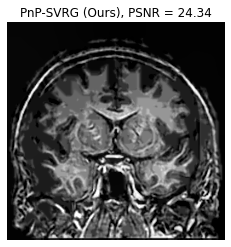

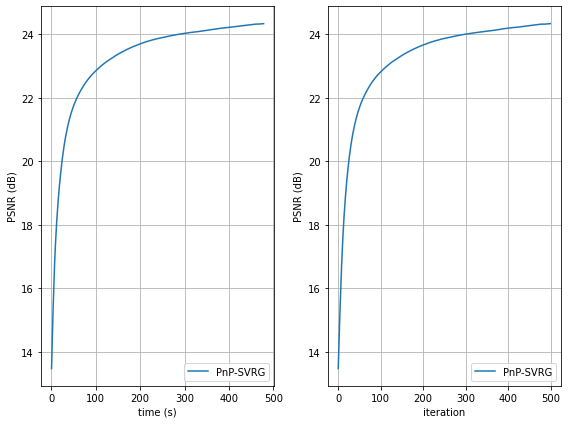

In [73]:
## Display output of PnP-SVRG algorithm
psnr_output_SVRG = peak_signal_noise_ratio(ORIG, output_SVRG)
svrg_fig = plt.figure()
ax = svrg_fig.add_subplot(1, 1, 1)
svrg_plot = plt.imshow(np.real(output_SVRG), cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-SVRG (Ours), PSNR = {psnr_output_SVRG:0.2f}")
ax.axis('off')

# Figure to display iteration count/ clock time vs PSNR for all algorithms
psnr_fig, psnr_ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

psnr_ax[0].plot(np.cumsum(time_per_iter_SVRG), psnr_per_iter_SVRG)

psnr_ax[1].plot(range(np.cumsum(time_per_iter_SVRG).size), psnr_per_iter_SVRG)

psnr_ax[0].set(xlabel='time (s)', ylabel='PSNR (dB)')
psnr_ax[0].legend(({'PnP-SVRG'}), loc='lower right')
psnr_ax[0].grid()

psnr_ax[1].set(xlabel='iteration', ylabel='PSNR (dB)')
psnr_ax[1].legend({"PnP-SVRG"}, loc='lower right')
psnr_ax[1].grid()

psnr_fig.tight_layout()

plt.show()

In [ ]:
## Set signal model parameters
num_trials = 20
prob = np.linspace(0, 1, num_trials) 							# percentage of Fourier coefficients measured
H, W = ORIG.shape[:2] 				# height and width of orig image
N = H*W 							# image dimension
sigma = 1							# noise level of measurements

## Run PnP-SVRG
T_outer = 50 				# Number of outer loop iterations
T_inner = 20 				# Number of inner loop iterations
eta_SVRG = .095 				# step size for SVRG
batch_size_SVRG=1400
NLM_filter = .015
patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

psnr_per_trial = []

for i in range(num_trials):
    ## Make measurements
    mask = np.random.choice([0, 1], size=(H,W), p=[1 - prob[i], prob[i]])	# generate random mask
    index = np.nonzero(mask)
    index = np.transpose(index)

    noises = np.random.normal(0, sigma, (H,W))						# generate random noise
    forig = np.fft.fft2(ORIG)										# fft2 of image
    y0 = np.multiply(forig, mask)									# noiseless measurements
    y = y0 + noises 												# noisy measurements

    ## Initialize variables
    x_init = np.absolute(np.fft.ifft2(y))
    mintmp = np.min(x_init)
    maxtmp = np.max(x_init)
    x_init = (x_init - mintmp) / (maxtmp - mintmp)
    x = np.copy(x_init)
    
    output_SVRG, time_per_iter_SVRG, psnr_per_iter_SVRG = PnP_SVRG_CSMRI(x_init, mask, y, eta_SVRG, \
                                                                     T_outer, T_inner, batch_size_SVRG, \
                                                                     NLM_filter, patch_kw, ORIG)
    psnr_per_trial.append(psnr_per_iter_SVRG[-1])
    
svrg_fig = plt.figure()
ax = svrg_fig.add_subplot(1, 1, 1)
svrg_plot = plt.plot(prob, psnr_per_trial)
ax.set_title(f"Sampling Rate vs. PSNR recovery")
ax.axis('on')
plt.show()

In [ ]:
svrg_fig = plt.figure()
ax = svrg_fig.add_subplot(1, 1, 1)
svrg_plot = plt.plot(prob, psnr_per_trial[20:40])
ax.set_title(f"Sampling Rate vs. PSNR recovery")
ax.axis('on')
plt.show()

$\begin{equation}
    \textbf{PnP-GD}(\boldsymbol{x}_0, \eta, T): \\
    \text{for } t = 1, 2, . . ., T \text{ do} \\
	\hspace{2ex} \boldsymbol{x}_t = \boldsymbol{x}_{t-1} - \eta \nabla \ell (\boldsymbol{x}_{t-1}) \\
    \hspace{2ex} \boldsymbol{x}_t = \text{denoise}_\sigma (\boldsymbol{x}_t) \\
    \text{end} \\
    \textbf{Output } \boldsymbol{x}_T
\end{equation}$


In [39]:
def PnP_GD_CSMRI(z, MASK, meas, eta, T, FILTER, patch, orig):
    ## Obtain info from inputs
    H, W = z.shape[:2] # image dimensions
    index = np.transpose(np.nonzero(MASK)) # nonzero indices of the mask
    
    ## Initialize time-keeping variables
    time_per_iter = []
    psnr_per_iter = []
    t1 = 0
    
    # Main PnP GD routine
    for i in range(T_GD):
        start_iter = time.time()
        
        ## Gradient Update
        v = full_grad(z, mask, y)
        z = z - eta * v
        psnr_per_iter.append(peak_signal_noise_ratio(orig, z))

        print(str(i) + " " + str(peak_signal_noise_ratio(orig, z)))
        
        # Denoising
        ztilde = np.copy(z)
        z = denoise_nl_means(np.real(ztilde), h=FILTER, fast_mode=True, **patch)
            
        ## Log timing
        stop_iter = time.time()
        time_per_iter.append(stop_iter-start_iter)
        
        mintmp = np.min(z)
        maxtmp = np.max(z)
        zp = (z - mintmp) / (maxtmp - mintmp)
        
        psnr_per_iter.append(peak_signal_noise_ratio(orig, z))

        ## Display PSNR at each iteration
        print(str(i) + " " + str(peak_signal_noise_ratio(orig, z)))
        t1 += 1
    return z, time_per_iter, psnr_per_iter

0 17.231530646305842
0 17.26320907716514
1 19.192831124616607
1 19.224024628097002
2 20.147480414624827
2 20.18029776198039
3 20.587724296485597
3 20.621369542443432
4 20.79698324520311
4 20.830114163326662
5 20.91129269326666
5 20.94354635294473
6 20.987569865458543
6 21.01880567905271
7 21.0481832414084
7 21.07835253666309
8 21.10180115630573
8 21.130958043837417
9 21.15188929334189
9 21.18010371259215
10 21.199894559629993
10 21.22723012525206
11 21.24646436731841
11 21.272904157816953
12 21.291842438841538
12 21.317380836868157
13 21.3361421908763
13 21.360746747875584
14 21.3793844709896
14 21.40299119777405
15 21.4215258213207
15 21.444140302277095
16 21.46257987721122
16 21.48433597426739
17 21.502688255794006
17 21.523669490466304
18 21.54195634078539
18 21.562322520292582
19 21.58057913170978
19 21.600466023514777
20 21.618732447336274
20 21.638231280426403
21 21.656542331301118
21 21.675691218385698
22 21.694077342949598
22 21.71282638980664
23 21.73130832012057
23 21.7495885

187 25.676073588524908
188 25.724042598633204
188 25.686483902202152
189 25.734566244477797
189 25.69676187869988
190 25.74495722950862
190 25.706913642217888
191 25.755221653585586
191 25.71694343215976
192 25.765362739318803
192 25.726858937792763
193 25.775387347014856
193 25.736662480993413
194 25.785299243675063
194 25.746363389789337
195 25.795106151585294
195 25.755962036292562
196 25.804808974998362
196 25.765451750276334
197 25.814402595756576
197 25.77484529274376
198 25.823898765897198
198 25.784137539957097
199 25.833291891846876
199 25.793336994973806
200 25.842590584282853
200 25.80244070709499
201 25.85179196910986
201 25.81144739132609
202 25.86089603214309
202 25.820364697398347
203 25.869908235164594
203 25.82919380636428
204 25.87883101714173
204 25.83792919858841
205 25.88765948966131
205 25.846573399473346
206 25.896394548022524
206 25.85513198694864
207 25.905044291793807
207 25.863615723611314
208 25.913618233217363
208 25.872018979545324
209 25.92210943008919
20

368 26.577322605059624
369 26.637575388493158
369 26.580427754407985
370 26.640730685801202
370 26.5835359257661
371 26.64388900276153
371 26.586650814707944
372 26.647053761868058
372 26.58976970212803
373 26.650222605202494
373 26.5928917536434
374 26.653394751399453
374 26.59601624333469
375 26.656568199728934
375 26.599146777836616
376 26.659747545734366
376 26.60227733220328
377 26.662927306774073
377 26.605415328028393
378 26.666114369858715
378 26.608559390055042
379 26.66930760563643
379 26.611702163458176
380 26.672499791242966
380 26.614847651082346
381 26.67569394633788
381 26.61799620843854
382 26.678891928698448
382 26.621146271124427
383 26.682090993829483
383 26.62429879683509
384 26.685292489551898
384 26.627458205818755
385 26.688500350717874
385 26.63061955638215
386 26.691710167483357
386 26.633782577014887
387 26.69492208692865
387 26.636951509566096
388 26.698140524221287
388 26.640125741715313
389 26.70136443599198
389 26.643303339537823
390 26.70459185694785
390 

549 27.160477567875606
550 27.230451046853887
550 27.163526057802034
551 27.23355654900562
551 27.1665692981259
552 27.23665711747763
552 27.169606824239416
553 27.23975148227716
553 27.172642758895748
554 27.242844699478248
554 27.17567676141174
555 27.245935396347424
555 27.178708228424455
556 27.249023530788925
556 27.181734249401618
557 27.2521059027342
557 27.18475864073932
558 27.255186971236544
558 27.1877785818763
559 27.258263009671595
559 27.19079614504001
560 27.261336664304025
560 27.19381062835999
561 27.264406478570447
561 27.19682029523842
562 27.267471838377713
562 27.19982753305596
563 27.270534689363593
563 27.20283425770091
564 27.27359676386719
564 27.20583864756129
565 27.27665596201545
565 27.20884104571049
566 27.279714082684063
566 27.211842218827826
567 27.282770891294213
567 27.214838246175766
568 27.285822524960352
568 27.217834434920782
569 27.288874523335586
569 27.22082980979306
570 27.29192607023115
570 27.22382310621894
571 27.294975877237178
571 27.2268

731 27.76490250104262
731 27.687559259647347
732 27.76772530781393
732 27.690321990285483
733 27.770543969053207
733 27.693082876479018
734 27.77336084139155
734 27.69583884418614
735 27.776172998836444
735 27.69858926217216
736 27.77897939778546
736 27.701337235376467
737 27.781783544310045
737 27.70407579697364
738 27.784579228876105
738 27.70681518551345
739 27.787375217797482
739 27.709553534130464
740 27.790169840988494
740 27.712286407140066
741 27.79295944162827
741 27.715012990126414
742 27.7957431140325
742 27.717736994016327
743 27.79852355971248
743 27.72045653739472
744 27.801299690765834
744 27.7231715355375
745 27.804071116290782
745 27.725887534807132
746 27.806843499222506
746 27.72859708923635
747 27.809610047078962
747 27.73129980038698
748 27.812369566168
748 27.73399801121417
749 27.815124072964675
749 27.736694355687575
750 27.817876543069456
750 27.73938952569084
751 27.820627303687836
751 27.74207754100651
752 27.823370835185536
752 27.74476548605932
753 27.82611

912 28.132571167965107
913 28.221638145806335
913 28.13477417575774
914 28.223888350901593
914 28.136973716332903
915 28.226134794791882
915 28.139170416016242
916 28.228378244689047
916 28.141367587930382
917 28.230621974004393
917 28.14356283059274
918 28.232863835648025
918 28.145756693116244
919 28.23510455944199
919 28.14794810599902
920 28.237342086378156
920 28.150138282302464
921 28.239578475856778
921 28.15232497771952
922 28.241811375378482
922 28.154508178054456
923 28.244040719741808
923 28.156688755501055
924 28.246267560910244
924 28.158870041637563
925 28.248494676637627
925 28.161048648815296
926 28.250718805810287
926 28.16322478105556
927 28.252940457531523
927 28.16540085840198
928 28.255162004798052
928 28.167575022073006
929 28.257382134129365
929 28.169750368128923
930 28.259603025693416
930 28.171922768799607
931 28.261820927255513
931 28.174095317510268
932 28.264038207824424
932 28.17626857009379
933 28.266256578234177
933 28.178441834811707
934 28.268474262899

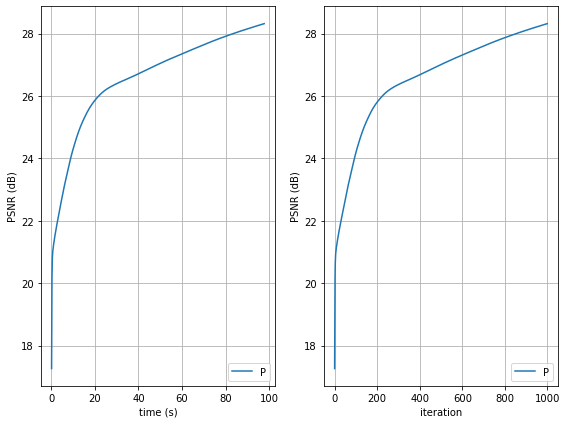

In [40]:
T_GD = 1000
eta_GD = .8
NLM_filter = .015			 		 

patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

output_GD, time_per_iter_GD, psnr_per_iter_GD = PnP_GD_CSMRI(x_init, mask, y, eta_GD, T_GD, NLM_filter, patch_kw, ORIG)

# Figure to display iteration count/ clock time vs PSNR for all algorithms
psnr_fig, psnr_ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

psnr_ax[0].plot(np.cumsum(time_per_iter_SVRG), psnr_per_iter_SVRG)

psnr_ax[1].plot(range(np.cumsum(time_per_iter_SVRG).size), psnr_per_iter_SVRG)

psnr_ax[0].set(xlabel='time (s)', ylabel='PSNR (dB)')
psnr_ax[0].legend(('PnP-SVRG'), loc='lower right')
psnr_ax[0].grid()

psnr_ax[1].set(xlabel='iteration', ylabel='PSNR (dB)')
psnr_ax[1].legend("PnP-SVRG", loc='lower right')
psnr_ax[1].grid()

psnr_fig.tight_layout()

plt.show()

(-0.5, 255.5, 255.5, -0.5)

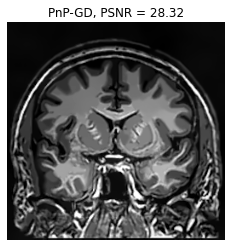

In [41]:
## Display output of PnP-GD
psnr_output_GD = peak_signal_noise_ratio(ORIG, output_GD)
gd_fig = plt.figure()
ax = gd_fig.add_subplot(1, 1, 1)
gd_plot = plt.imshow(output_GD, cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-GD, PSNR = {psnr_output_GD:0.2f}")
ax.axis('off')

$\begin{equation}
    \textbf{PnP-SGD}(\boldsymbol{x}_0, \eta, T): \\
    \text{for } t = 1, 2, . . ., T \text{ do} \\
    \hspace{2ex} \text{pick } i_t \in \{ 1, ..., m \} \text{ randomly} \\
	\hspace{2ex} \boldsymbol{x}_t = \boldsymbol{x}_{k-1} - \eta \nabla \ell_{i_t} (\boldsymbol{x}_{t-1}) \\
    \hspace{2ex} \boldsymbol{x}_t = \text{denoise}_\sigma (\boldsymbol{x}_t) \\
    \text{end} \\
    \textbf{Output } \boldsymbol{x}_T
\end{equation}$

In [ ]:
def PnP_SGD_CSMRI(z, MASK, meas, eta, T, batch_size, FILTER, patch, orig):
    ## Obtain info from inputs
    H, W = z.shape[:2] # image dimensions
    index = np.transpose(np.nonzero(MASK)) # nonzero indices of the mask
    
    ## Initialize time-keeping variables
    time_per_iter = []
    psnr_per_iter = []
    t2 = 0
    
    # Main PnP SGD routine
    for i in range(T):
        start_iter = time.time()
        # Update variables
        ind = get_batch(batch_size, H, W, index)
        v = stoch_grad(z, MASK, meas, ind)
        z = z - eta * v

        # Denoising
        ztilde = np.copy(z)
        z = denoise_nl_means(np.real(ztilde), h=FILTER, fast_mode=True, **patch)
        stop_iter = time.time()
        time_per_iter.append(stop_iter-start_iter)
        psnr_per_iter.append(peak_signal_noise_ratio(orig, z))

        print(str(i) + " " + str(peak_signal_noise_ratio(orig, z)))
        t2 += 1
    return z, time_per_iter, psnr_per_iter

In [ ]:
T_SGD = 1000
eta_SGD = 1 / L				# step size for GD
batch_size_SGD = 1000
NLM_filter = .015			 		 

patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

output_SGD, time_per_iter_SGD, psnr_per_iter_SGD = PnP_SGD_CSMRI(x_init, mask, y, eta_SGD, T_SGD, batch_size_SGD, \
                                                                 NLM_filter, patch_kw, ORIG)



In [ ]:
## Display output of PnP-SGD
psnr_output_SGD = peak_signal_noise_ratio(ORIG, output_SGD)
sgd_fig = plt.figure()
ax = sgd_fig.add_subplot(1, 1, 1)
sgd_plot = plt.imshow(output_SGD, cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-SGD, PSNR = {psnr_output_SGD:0.2f}")
ax.axis('off')



(Need to rewrite code. originally taken from: https://github.com/uclaopt/Provable_Plug_and_Play and not working)

$\begin{equation}
    \textbf{PnP-ADMM}(\boldsymbol{x}_0, \boldsymbol{v}_0, \boldsymbol{u}_0, \eta, T): \\
    \text{for } t = 1, 2, . . ., T \text{ do} \\
	\hspace{2ex} \boldsymbol{x}_t = \text{prox}_d (\boldsymbol{v}_{t-1} - \boldsymbol{u}_{t-1}; \eta) \\
	\hspace{2ex} \boldsymbol{v}_t = \text{denoise}_\sigma (\boldsymbol{x}_{t} + \boldsymbol{u}_{t-1}) \\
	\hspace{2ex} \boldsymbol{u}_{t} = \boldsymbol{u}_{t-1} + (\boldsymbol{x}_{t} - \boldsymbol{v}_t) \\
    \text{end}
\end{equation}$

$\text{prox}_g (\boldsymbol{z}; \eta) \overset{\Delta}{=} {\arg\min}_{\boldsymbol{x}} \left\{ g(\boldsymbol{x}) + \frac{1}{2 \eta} \| \boldsymbol{x} - \boldsymbol{z} \|_2^2 \right\}$

In [ ]:
alpha = 2.0
T_ADMM = 20
NLM_filter = .015			 		 

x = np.copy(x_init)
print("Initial PSNR = " + str(peak_signal_noise_ratio(orig, x)))
t3 = 0

patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

time_per_iter_ADMM = []
psnr_per_iter_ADMM = []

v = np.copy(x)
u = np.zeros((H,W), dtype=np.float64)

""" Main loop. """
for i in range(T_ADMM):
    start_iter = time.time()
    xold = np.copy(x)
    vold = np.copy(v)
    uold = np.copy(u)
    """ Update variables. """

    vtilde = np.copy(x+u)
    vf = np.fft.fft2(vtilde)
    La2 = 1.0/2.0/alpha
    vf[index] = (La2 * vf[index] + y[index]) / (1.0 + La2)
    v = np.real(np.fft.ifft2(vf))

    """ Denoising step. """

    xtilde = np.copy(2*v - xold - uold)
    mintmp = np.min(xtilde)
    maxtmp = np.max(xtilde)
    xtilde = (xtilde - mintmp) / (maxtmp - mintmp)

    # the reason for the following scaling:
    # our denoisers are trained with "normalized images + noise"
    # so the scale should be 1 + O(sigma)
    scale_range = 1.0 + sigma/255.0/2.0 
    scale_shift = (1 - scale_range) / 2.0
    xtilde = xtilde * scale_range + scale_shift


    # pytorch denoising model
    x = denoise_nl_means(np.real(xtilde), h=NLM_filter, fast_mode=True, **patch_kw)

    # scale and shift the denoised image back
    x = (x - scale_shift) / scale_range
    x = x * (maxtmp - mintmp) + mintmp

    """ Update variables. """
    u = uold + xold - v
    stop_iter = time.time()

    time_per_iter_ADMM.append(stop_iter-start_iter)
    psnr_per_iter_ADMM.append(peak_signal_noise_ratio(orig, x))
    print(str(i) + " " + str(peak_signal_noise_ratio(orig, x)))
    t3 += 1

output_ADMM = np.copy(x)

In [ ]:
## Display output of PnP-ADMM
psnr_output_ADMM = peak_signal_noise_ratio(ORIG, output_ADMM)
admm_fig = plt.figure()
ax = admm_fig.add_subplot(1, 1, 1)
admm_plot = plt.imshow(output_ADMM, cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-ADMM, PSNR = {psnr_output_ADMM:0.2f}")
ax.axis('off')

$\begin{equation}
	\textbf{PnP-LSVRG}(\boldsymbol{x}_0, \eta, T, p): \\
    \text{Initialize } \boldsymbol{\tilde{x}} \\
	\text{for } t = 1, 2, . . ., T \text{ do} \\
	\hspace{2ex} \boldsymbol{w} = \underbrace{\nabla d(\tilde{\boldsymbol{x}})}_{\text{full gradient}} \\
    \hspace{2ex} \text{pick } i_t \in \{ 1, ..., n \} \text{ randomly} \\
	\hspace{2ex} \boldsymbol{v}_t = \underbrace{\nabla d_{i_t} (\boldsymbol{x}_{t-1}) - \nabla d_{i_t} (\tilde{\boldsymbol{x}}) + \boldsymbol{w}}_{\text{stochastic variance-reduced gradient}} \\
	\hspace{2ex} \boldsymbol{x}_t = \text{denoise}_\sigma (\boldsymbol{x}_{t-1} - \eta \boldsymbol{v}_t) \\
	\hspace{2ex} \text{Update} \hspace{1ex} \tilde{\boldsymbol{x}} = \boldsymbol{x}_t 
\hspace{2ex} \text{ w.p. } p \\ \text{end} \\
    \textbf{Output } \boldsymbol{x}_T
\end{equation}$

In [ ]:
def PnP_LSVRG_CSMRI(z, MASK, meas, eta, T, batch_size, p, FILTER, patch, orig):
    ## Obtain info from inputs
    H, W = z.shape[:2] # image dimensions
    index = np.transpose(np.nonzero(MASK)) # nonzero indices of the mask
    
    ## Initialize time-keeping variables
    time_per_iter = []
    psnr_per_iter = []
    t4 = 0
    
    # Main PnP SVRG routine
    w = np.copy(z)
    for i in range(T):
        # outer loop
        mu = full_grad(w, MASK, meas)   	# Average gradient
        # 	w = np.copy(x) 					# reference point
        start_iter = time.time()

        # inner loop
        ind = get_batch(batch_size, H, W, index) 	# Get batch index(indices) in terms of (row, col)

        start_grad = time.time()
        v = stoch_grad(z, MASK, meas, ind) - stoch_grad(w, MASK, meas, ind) + mu
        z = z - eta*v

        # Denoising
        ztilde = np.copy(z)
        z = denoise_nl_means(np.real(ztilde), h=FILTER, fast_mode=True, **patch)

        # update reference point with probability 1-p
        if np.random.random() > p:
            w = np.copy(z)

        stop_iter = time.time()
        print(str(i) + " " + str(peak_signal_noise_ratio(orig, z)))
        time_per_iter.append(stop_iter - start_iter)
        psnr_per_iter.append(peak_signal_noise_ratio(orig, z))

        t4 += 1
    return z, time_per_iter, psnr_per_iter

In [ ]:
T_LSVRG = 10 				# Number of outer loop iterations
eta_LSVRG = 1 / L				# step size for SVRG
p_LSVRG = .2						# probability of NOT updating reference point
batch_size_LSVRG=30000
NLM_filter = .015
patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

output_LSVRG, time_per_iter_LSVRG, psnr_per_iter_LSVRG = PnP_LSVRG_CSMRI(x_init, mask, y, eta_LSVRG, T_LSVRG, \
                                                                         batch_size_LSVRG, p_LSVRG, \
                                                                         NLM_filter, patch_kw, ORIG)

In [ ]:
## Display output of PnP-L-SVRG
psnr_output_LSVRG = peak_signal_noise_ratio(orig, output_LSVRG)
lsvrg_fig = plt.figure()
ax = lsvrg_fig.add_subplot(1, 1, 1)
lsvrg_plot = plt.imshow(output_LSVRG, cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-L-SVRG, PSNR = {psnr_output_LSVRG:0.2f}")
ax.axis('off')

(not yet working, need to learn how to choose parameters)

$\begin{equation}
	\textbf{PnP-LKatyusha}(\theta_1, \theta_2, p \in (0, 1], T): \\
    \text{Initialize } \boldsymbol{y}_0 = \boldsymbol{w}_0 = \boldsymbol{z}_0 \in \mathbb{R}^n, \text{ stepsize } \eta = \frac{\theta_2}{(1 + \theta_2) \theta_1} \text{ and set } \sigma = \frac{\mu}{L}\\
	\text{for } t = 1, 2, . . ., T \text{ do} \\
	\hspace{2ex} \boldsymbol{x}_t = \theta_1 \boldsymbol{z}_t + \theta_2 \boldsymbol{w}_t + (1 - \theta_1 - \theta_2) \boldsymbol{y}_k \\
    \hspace{2ex} \text{pick } i_t \in \{ 1, ..., n \} \text{ randomly} \\
	\hspace{2ex} \boldsymbol{g}_t = \nabla \ell_i (\boldsymbol{x}_t) - \nabla_i \ell_i (\boldsymbol{w}_t) + \nabla \ell (\boldsymbol{w}_t) \\
	\hspace{2ex} \boldsymbol{z}_{t+1} = \frac{1}{1 + \eta \sigma} (\eta \sigma \boldsymbol{x}_t + \boldsymbol{z}_t - \frac{\eta}{L} \boldsymbol{g}_t) \\
    \hspace{2ex} \boldsymbol{y}_{t+1} = \boldsymbol{x} + \theta_1 (\boldsymbol{z}_{t+1} - \boldsymbol{z}_t) \\
	\hspace{2ex} \text{Update} \hspace{1ex} \boldsymbol{w}_{t+1} = \boldsymbol{y}_t
\hspace{2ex} \text{ w.p. } p \\ \text{end} \\
    \textbf{Output } \boldsymbol{x}_T
\end{equation}$

In [ ]:
T_LKatyusha = 10 				# Number of outer loop iterations

p = .2						# probability of NOT updating reference point
theta1 = .1
theta2 = .1
eta_LKatyusha = theta2/((1+theta2)*theta1)				# step size for SVRG
mu = 1
L = 1
sigma = mu/L

batch_size_LKatyusha=30000
NLM_filter = .015
patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

time_per_iter_LKatyusha = []
psnr_per_iter_LKatyusha = []

y = np.copy(x_init)
w = np.copy(x_init)
z = np.copy(x_init)

t5 = 0
# Main PnP SVRG routine
for i in range(T_LKatyusha):
    z_old = np.copy(z)
    x = theta1*z + theta2*w + (1 - theta1 - theta2)*y
    start_iter = time.time()

    # inner loop
    ind = get_batch(batch_size_LKatyusha, H, W, index) 	# Get batch index(indices) in terms of (row, col)

    start_grad = time.time()
    g = stoch_grad(x, mask, y, ind) - stoch_grad(w, mask, y, ind) + full_grad(w, mask, y)
    z = (1 / (1 + eta_LKatyusha*sigma))*(eta_LKatyusha*sigma*x + z - eta_LKatyusha / L * g)
    y = x + theta1*(z - z_old)
    
    # Denoising
    wtilde = np.copy(w)

    # denoise
    w = denoise_nl_means(np.real(wtilde), h=NLM_filter, fast_mode=True, **patch_kw)
    print(str(i) + " " + str(peak_signal_noise_ratio(orig, w)))

    # update reference point with probability 1-p
    if np.random.random() > p:
        w = np.copy(y)
        
    stop_iter = time.time()
    time_per_iter_LKatyusha.append(stop_iter - start_iter)
    psnr_per_iter_LKatyusha.append(peak_signal_noise_ratio(orig, w))

    t5 += 1
output_LKatyusha = w

In [ ]:
## Display output of PnP-L-Katyusha
psnr_output_LKatyusha = peak_signal_noise_ratio(orig, output_LKatyusha)
lkatyusha_fig = plt.figure()
ax = lkatyusha_fig.add_subplot(1, 1, 1)
lkatyusha_plot = plt.imshow(output_LKatyusha, cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-L-Katyusha, PSNR = {psnr_output_LKatyusha:0.2f}")
ax.axis('off')

In [ ]:
# Figure to display iteration count/ clock time vs PSNR for all algorithms
psnr_fig, psnr_ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

psnr_ax[0].plot(np.cumsum(time_per_iter_SVRG), psnr_per_iter_SVRG)
psnr_ax[0].plot(np.cumsum(time_per_iter_GD), psnr_per_iter_GD)
psnr_ax[0].plot(np.cumsum(time_per_iter_SGD), psnr_per_iter_SGD)
psnr_ax[0].plot(np.cumsum(time_per_iter_ADMM), psnr_per_iter_ADMM)
psnr_ax[0].plot(np.cumsum(time_per_iter_LSVRG), psnr_per_iter_LSVRG)
psnr_ax[0].plot(np.cumsum(time_per_iter_LKatyusha), psnr_per_iter_LKatyusha)

psnr_ax[1].plot(range(t0), psnr_per_iter_SVRG)
psnr_ax[1].plot(range(t1), psnr_per_iter_GD)
psnr_ax[1].plot(range(t2), psnr_per_iter_SGD)
psnr_ax[1].plot(range(t3), psnr_per_iter_ADMM)
psnr_ax[1].plot(range(t4), psnr_per_iter_LSVRG)
psnr_ax[1].plot(range(t5), psnr_per_iter_LKatyusha)

psnr_ax[0].set(xlabel='time (s)', ylabel='PSNR (dB)')
psnr_ax[0].legend(('PnP-SVRG', 'PnP-GD', 'PnP-SGD', 'PnP-ADMM', 'PnP-LSVRG', 'PnP-LKatyusha'), loc='lower right')
psnr_ax[0].grid()

psnr_ax[1].set(xlabel='iteration', ylabel='PSNR (dB)')
psnr_ax[1].legend(('PnP-SVRG','PnP-GD', 'PnP-SGD', 'PnP-ADMM', 'PnP-LSVRG', 'PnP-LKatyusha'), loc='lower right')
psnr_ax[1].grid()

psnr_fig.tight_layout()

plt.show()